<a href="https://colab.research.google.com/github/mgfrantz/CodingNomads-Intro-To-Deep-Learning-Labs/blob/master/Torch_Data_API_workset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction to Torch Data API

You're probably already very familiar with sklearn's .fit() method. It's a nice clean API that takes your data, usually x_train and y_train arrays or dataframes, and feeds it to your model. In this paradigm, you can generally fit all your data in the memory of your device, whether it be your local computer or a cloud instance.

Why might the way we load data be important for deep learning?

With deep learning, we need to think about feeding data to our model a bit differently, for a few reasons. First, we will often work with datasets that don't fit in memory. For example, you can easily load tabular data with 1,000,000 rows into memory in a pd.DataFrame. However, you may not be able to load the same number of images into memory. In this lesson, we'll work with both in-memory and out-of-memory datasets.

Second, deep learning models usually benefit from minibatch gradient descent. Deep learning models don't fit all the data at once - they minimize loss for every batch of data (also sometimes referred to as minibatches). For this reason, don't want to feed all the data to the model at the same time. Additionally, randomizing the samples that appear together in each batch helps reduce overfitting by making it more difficult to "memorize" data.

Optimizing the way you load and feed data to your model can sometimes be complicated. Torch offers a powerful and flexible data api to help with this challenge. There are two main concepts in this API we will cover in this lesson:

the Dataset, which loads your data from memory, disk, or external storage
the DataLoader, which sampeles items from a dataset and returns them as a batch.
In this lesson, we'll become familiar with these two objects. Later on in the course, we will use some higher level data libraries that have other mechanisms for loading data, but these concepts remain fundamental.

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import os
from sklearn.preprocessing import StandardScaler
from multiprocessing import cpu_count

In [ ]:
# Load data into memory
# These datasets come come pre-packaged with colab, so it's best to run this lesson there.
housing = pd.read_csv('sample_data/california_housing_train.csv')
housing_test = pd.read_csv('sample_data/california_housing_test.csv')

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
housing.agg(['mean','std'])   #Aggregate using one or more operations over the specified axis. In our case each column

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387


In [ ]:
x_train = housing.drop('median_house_value', axis=1)
y_train = housing.median_house_value.values       #It`s creating an array

x_valid = housing_test.drop('median_house_value', axis=1)
y_valid = housing_test.median_house_value.values   #It`s creating an array

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Introducing the Dataset object
In the past, we fed objects that hold our data like dataframes or arrays directly into our model. In deep learning, we need a few specialized objects that help us take data from storage (memory, disk, etc) and feed it to our model. The first of these objects is the Dataset.

The torch.utils.data.Dataset object is a flexible object that "holds" your data. All you need to do is create two methods:

__len__(self): This method allows you to call len on your dataset. This method should return how many items are in this dataset.
__getitem__(self, idx): This method allows you to index into the object. It answers the question of how should the dataset fetch a single item.
Let's create a simple dataset and look at some of its behavior.

In [ ]:
# Check that the means of each column are close to 0
assert np.allclose(x_train_scaled.mean(axis=0), np.zeros(x_train_scaled.shape[1]))
# Check that the stds of each column are close to 1
assert np.allclose(x_train_scaled.std(axis=0), np.ones(x_train_scaled.shape[1]))

Introducing the Dataset object

In the past, we fed objects that hold our data like dataframes or arrays directly into our model. In deep learning, we need a few specialized objects that help us take data from storage (memory, disk, etc) and feed it to our model. The first of these objects is the Dataset.

The torch.utils.data.Dataset object is a flexible object that "holds" your data. All you need to do is create two methods:

__len__(self): This method allows you to call len on your dataset. This method should return how many items are in this dataset.
__getitem__(self, idx): This method allows you to index into the object. It answers the question of how should the dataset fetch a single item.
Let's create a simple dataset and look at some of its behavior.

In [ ]:
class HousingDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        # What are some other ways we could do this? we could use X because they have same amount of rows
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_ds = HousingDataset(x_train_scaled, y_train)    #defining as the class
valid_ds = HousingDataset(x_valid_scaled, y_valid)

In [ ]:
# What are the number of items in each dataset?
len(train_ds), len(valid_ds)

(17000, 3000)

In [ ]:
# What is the x and y at a given index?
idx = 8

In [ ]:
x, y = train_ds[idx]
x, y

(array([ 2.47972161, -0.94289358,  0.42987474,  0.98415173,  1.50796844,
         1.48492555,  1.44282004, -0.89375701]),
 58400.0)

In [ ]:
train_ds.__getitem__(8)

(array([ 2.47972161, -0.94289358,  0.42987474,  0.98415173,  1.50796844,
         1.48492555,  1.44282004, -0.89375701]),
 58400.0)

## Exercise 4.1: Perform some sanity checks

Use `assert` to perform the following sanity checks.
For a random `(x, y)` item from `train_ds` ad a given index...

* check that the `x` value is the same as the corresponding value from `x_train_scaled` at the same index
* check that the `y` value is the same as the corresponding value from `y_train` at the same index

In [ ]:
# Choose an index in your dataset
idx = 3
# Fetch an item at that index from train_ds
x, y = train_ds[idx]
# check that the x value is the same as the corresponding value from x_train_scaled at the same index
assert (x==x_train_scaled[idx]).all()
# check that the y value is the same as the corresponding value from y_train at the same index
assert y==y_train[idx]

Introducing the DataLoader

In this section, we'll create a torch.utils.data.DataLoader for our train and validation datasets. Dataloaders take items from our dataset and combine them into batches. We can also do things like shuffle our samples, parallelize data loading, and apply transformations as part of the dataloader.

We'll also get some more familiarity with some terminology:

an epoch is defined as one time through your entire dataset
a batch is a sample of data that you feed to your model
Let's start with a simple example. First, let's define a batch size and numbert of workers. The batch size is the number of items you will feed to your model at a time. Because fetching data can be a CPU-intensive task (reading files from disk, opening them, transforming them, etc), we can have multiple workers loading data for us at the same time to speed this process up. We can increase the number of workers to parallelize this work.

In [ ]:
BATCH_SIZE = 64
N_WORKERS = cpu_count()
print(f"""
In this example, each batch will contain {BATCH_SIZE} items.
We will use {N_WORKERS} workers to load data more efficiently.
""")


In this example, each batch will contain 64 items.
We will use 2 workers to load data more efficiently.



https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Now that we've defined the batch size and number of workers, we can create our dataloader. This part is easy - we just pass our dataset and other hyperparameters to the DataLoader class.

Below, we're creating the dataloader for our training dataset. The purpose of the training dataset is to optimize the parameters of our model through gradient descent. Shuffling the data in each batch helps prevent overfitting by showing each item to the model in a different context, helping prevent the "memorization" of data. For a more detailed explanation, please see this stack exchange post.

https://stats.stackexchange.com/questions/245502/why-should-we-shuffle-data-while-training-a-neural-network/311318#311318

In [ ]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, # we generally want to shuffle the train dataloader
    num_workers=N_WORKERS
)

## Exercise 4.2: Create the `valid_dl`

Create the validation dataloader below.
This can be mostly the same as the `train_dl`, but `shuffle` should be set to `False`.
Think critically about how you're going to evaluate your model.
Why is setting `shuffle=False` in the validation dataloader a good idea?

In [ ]:
valid_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=False, #  we don`t want to shuffle the validation dataloader -- we want to measure our loss. If we shuffle will affect our weights.
    num_workers=N_WORKERS
)

Now that we have our dataloaders, how do we use them? We iterate over them! An epoch is one full pass through our data. During each epoch, we will use our train dataloader to optimize our model's parameters, and the validation dataloader to calculate metrics and detect overfitting.

Here's the general pattern in pseudocode:

for epoch in n_epochs:
    for x_batch, y_batch in train_dl:
        make inferences
        calculate loss
        backpropagation (calculate gradients)
        update weights

    for x_batch, y_batch in valid_dl:
        make inferences
        calculate loss (no gradients required here!)

In this notebook, let's ignore the training and focus on the data loading. What happens when we iterate over a dataloader? Let's pull one batch and inspect that object.

In [ ]:
# Pull one batch of data
for batch in train_dl:
    break

In [ ]:
# What's the type? The length?
type(batch), len(batch)     #each batch is a list with 2 items

(list, 2)

In [ ]:
# This looks like our X
batch[0].shape      #64=batch size, 8=features

torch.Size([64, 8])

In [ ]:
# This looks like our y
batch[1].shape

torch.Size([64])

In [ ]:
for x_batch, y_batch in train_dl:   #doing the same as before just unpacking
    break

In [ ]:
x_batch.shape, y_batch.shape

(torch.Size([64, 8]), torch.Size([64]))

In [ ]:
x_batch

tensor([[ 0.5646, -0.7090, -0.1263,  3.7444,  2.1367,  1.8134,  2.2126,  4.6360],
        [-0.8518,  1.0877,  1.8600, -0.6081, -0.5490, -0.0536, -0.4973, -1.0783],
        [ 0.1457, -0.6294,  1.8600, -0.1856, -0.2833, -0.4257, -0.2711,  0.1265],
        [ 1.3775, -0.8540,  0.5093, -1.0641, -1.1303, -1.1078, -1.2021, -0.2447],
        [-0.1336,  0.5356,  0.2710,  0.1025,  0.1793,  0.2400,  0.1789, -0.7625],
        [-0.8119,  1.4246, -1.0002, -0.4081, -0.6060, -0.5720, -0.5831,  0.4892],
        [-0.9415,  1.3778,  1.8600, -0.2925, -0.3023, -0.5267, -0.3049, -0.3078],
        [ 0.6843, -0.7043,  1.2244, -0.6536, -0.5111, -0.3429, -0.5701,  0.0829],
        [ 1.3227, -0.8774, -1.2386,  3.7811,  3.7666,  2.4711,  3.7809, -0.8211],
        [-0.8169,  0.2409, -1.3180,  0.5020,  0.4047,  0.7906,  0.4233,  0.0425],
        [-0.9116,  1.3965,  0.5888, -0.1136, -0.0081, -0.1782,  0.0358, -0.4862],
        [-1.4453,  1.0550,  0.5093, -0.0696, -0.3094, -0.5380, -0.3335,  2.5968],
        [-1.0014

In [ ]:
y_batch

tensor([500001.,  54600., 349000., 100000.,  68100., 147000., 236100., 170600.,
        123400., 135000., 136600., 500001., 178000., 185800., 303100., 201000.,
        367300.,  82000.,  82100., 294900., 163300.,  88200., 214900.,  90200.,
        109800., 190400., 112700., 385700.,  65000., 106300., 171800., 243800.,
        189600., 107900., 191100., 218300., 137500., 500001., 152500., 174800.,
         60000., 214500., 500001., 252100.,  73400., 351500., 376600., 105800.,
        284800., 146000., 210100., 196400., 500001., 191100.,  87500., 108900.,
        230000., 250000., 291100., 260600., 186500., 170500.,  60600., 267400.],
       dtype=torch.float64)

## Exercise 4.3: Exploring the `DataLoader`

Explore the `train_dl` object to answer the following questions.

1. How many batches are there in `train_dl`? How many items?
1. Are all the batches the same size? What's the minimum and maximum batch sizes? If there is a difference here, why might that be occurring?
1. Can we index into `train_dl`? Does this behavior make sense? Why?

In [ ]:
# Your code here
total_samples=0
total_batches=0
batch_sizes=[]

for x_b, y_b in train_dl:
  total_samples += len(x_b)
  batch_sizes.append(len(x_b))
  total_batches+=1

print(total_samples, total_batches, min(batch_sizes), max(batch_sizes))

try:
  train_dl[0]

except:
  print("we can`t index into the train_dl object")

17000 266 40 64
we can`t index intp the train_dl object


1700 can`t be ivided by 64 that`s why there is abatch size of 40

A More Complicated Example: Out-of-memory (OOM) Datasets - Working with Images

Out-of-memory (OOM) datasets: Working with images
In this example, we'll load some images lazily to show some of the flexibility of the data api. We'll be using one fastai's version of the classic CIFAR 10 dataset.

It`s not a good idea to load in memory big size files like images

In [ ]:
# We're just using fastai for the datasets for now.
# We'll learn how to use it for modeling later on.
!pip install -Uqq fastai

In [ ]:
# Download and extract the data
from fastai.data.all import URLs, untar_data
from fastcore.basics import Path
from PIL import Image
import numpy as np

path = untar_data(URLs.CIFAR)

How the data is organized

.
├── labels.txt
├── test
│   ├── airplane
│   │      ├── 199_airplane.png
│   │      └── ...
│   ├── automobile
│   ├── bird
│   ├── cat
│   ├── deer
│   ├── dog
│   ├── frog
│   ├── horse
│   ├── ship
│   └── truck
└── train
    ├── airplane
    ├── automobile
    ├── bird
    ├── cat
    ├── deer
    ├── dog
    ├── frog
    ├── horse
    ├── ship
    └── truck

Let's desgn a dataset to load this data. There are a number of things we'll need to do that we'll build functions for in a modular fashion. These things include:

Listing image files in a path object

Extracting the label of the image based on the file name

Loading the image into memory

Turning the image into a tensor

Scaling the values in images between 0 and 1

Making images the same size so they fit into a batch

Keep an eye out for exercises - you will be asked to complete some of these functions.

NOTE: The Path object is a really nice tool for navigating and exploring data on disk. You may be familiar with pathlib.Path; fastcore.basics.Path is similar with a few extra methods.

## Exercise 4.4: Exploring data on disk

The variable `path` refers to where our raw data is.
The directory structure is listed above.
In this exercise, we'll explore what's in that directory.
Using `path`, answer the following questions:

1. What files or directories are in `path`?
1. What is contained in `path/'train'`?
1. Find the paths for 10 images of airplanes from the train dataset.
1. If we had to label the image from its path, how might we do that?

In [ ]:
# Your code here
list(path.ls())

[Path('/root/.fastai/data/cifar10/test'),
 Path('/root/.fastai/data/cifar10/labels.txt'),
 Path('/root/.fastai/data/cifar10/train')]

In [ ]:
list((path/'train').ls())

[Path('/root/.fastai/data/cifar10/train/ship'),
 Path('/root/.fastai/data/cifar10/train/truck'),
 Path('/root/.fastai/data/cifar10/train/automobile'),
 Path('/root/.fastai/data/cifar10/train/dog'),
 Path('/root/.fastai/data/cifar10/train/cat'),
 Path('/root/.fastai/data/cifar10/train/bird'),
 Path('/root/.fastai/data/cifar10/train/deer'),
 Path('/root/.fastai/data/cifar10/train/airplane'),
 Path('/root/.fastai/data/cifar10/train/horse'),
 Path('/root/.fastai/data/cifar10/train/frog')]

In [ ]:
list((path/'train'/'airplane').ls()[:10])

[Path('/root/.fastai/data/cifar10/train/airplane/44830_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/42010_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/24600_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/11783_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/5580_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/37872_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/23126_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/7060_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/27460_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/14689_airplane.png')]

Create utility functions

In [ ]:
def list_png_files(path):
    return list(path.glob('**/*.png'))    #looking in all the folders looking for .png files

In [ ]:
sample_files = list_png_files(path/'train'/'airplane')[:10]
sample_files

[Path('/root/.fastai/data/cifar10/train/airplane/44830_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/42010_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/24600_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/11783_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/5580_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/37872_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/23126_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/7060_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/27460_airplane.png'),
 Path('/root/.fastai/data/cifar10/train/airplane/14689_airplane.png')]

In [ ]:
def label_from_path_parent(path:Path) -> str:
    return path.parent.name

In [ ]:
# Sanity check for label_from_parent_path
assert label_from_path_parent(Path('/root/.fastai/data/cifar10/train/horse/42500_horse.png')) == 'horse'

In [ ]:
def load_image_and_label(path):
    img = Image.open(path)    #From python object ('Image)
    label = label_from_path_parent(path)
    return img, label

airplane


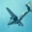

In [ ]:
img, label = load_image_and_label(sample_files[0])
print(label)
img

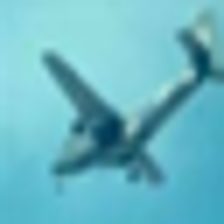

In [ ]:
# Let's resize this image and inspect what it looks like
img.resize((224,224))

## Exercise 4.5: The `CifarDataset`

Use the `list_image_files` and `load_image_and_label` functions to complete the `CifarDataset`.

In [ ]:
class CifarDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.files = list_png_files(path)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return load_image_and_label(self.files[idx])

In [ ]:
train_cifar = CifarDataset(path/'train')

truck


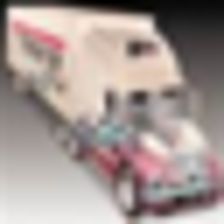

In [ ]:
img, label = train_cifar[8000]
print(label)
img.resize((224, 224))

In this lesson, we examined how the CIFAR-10 dataset is organized on disk. This is one great example of how to organize data, since the labels are implied by the file structure. We'll see this design pattern used with image classification frequently. We also created a few utility functions to help us easily create a torch.utils.data.Dataset object that will load these images as tensors. Finally, we created our own dataset object.

From dataset to dataloader using a collate_fn

From dataset to dataloader: collate_fn

We no longer have to keep them all in memory - we can load them on the fly. However, when we load data, they're still images. But we still have a few tasks we need to complete before we can feed them to a model. Models don't know how to work directly with images, we require them to be tensors. One way to do that would be to turn them into tensors in the dataset object. Here, we introduce an alternate method.

This is where collate_fn comes in - this is a function that's applied to a single batch of data that transofrms it after it's loaded. Before we write this function, let's write some more utility functions.

First, our images are in PIL.Image format. They should be torch.Tensors before we feed them to our model. Second, images contain pixel values from 0-255 as integers. We'd like them to be floats scaled to something much smaller - let's just scale them to between 0 and 1 for now. Luckily, our images are all the same size - if they weren't, we'd want to resize them to all be the same shape. Finally, PIL.Images have a shape of (height, width, num_channels), but torch likes to work with images in the format (num_channels, height, width) - we'll make this adjustment using Tensor.permute.

In [ ]:
def img_to_scaled_tensor(img, channels_first=True):
    t = torch.tensor(np.array(img) / 255).float()
    if channels_first:
        return t.permute(2, 0, 1)
    return t

Takes in an image and turns it into tensor

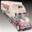

In [ ]:
img

In [ ]:
img_t = img_to_scaled_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

With regard to our labels, they're still in string format, which is not something our loss functions understand.
Let's convert these to label indices.

In [ ]:
classes = {d.name:i  for i, d in enumerate((path/'train').ls())}
classes

{'ship': 0,
 'truck': 1,
 'automobile': 2,
 'dog': 3,
 'cat': 4,
 'bird': 5,
 'deer': 6,
 'airplane': 7,
 'horse': 8,
 'frog': 9}

In [ ]:
def class_to_idx(class_name):
    return classes.get(class_name)

Now that we have our utility functions, let's build our collate_fn.

What is a collate_fn? This is a function that takes in items from our dataset and packages them into a batch. If our data already comes out as a tensor, we don't need to do anything here. But if our data is not just a standard tensor, we may have to apply some special logic to process it and transform it into a tensor. While the following process could have been done in our dataset object, we'll create a collate function that accepts an iterator of tuples from our dataset and turns them into a batch.

In [ ]:
def collate_fn(batch):
    # the batch comes in the format ((x1,y1),(x2,y2),...(xn,yn)).
    #Let`s split this up into xs and our ys
    xs, ys = list(zip(*batch))
    #Let`s create a tensor that concatenates all our images on a new axis.
    #Is there another way to do this?
    xs = torch.cat([img_to_scaled_tensor(i).unsqueeze(0) for i in xs], dim=0)   #The class we created above, unsqueeze first dimension
    #Let`s create another tensor that combines all our class labels.
    ys = torch.tensor([class_to_idx(i) for i in ys])

    return xs, ys

In [ ]:
# Test the collate function
items = (train_cifar[0], train_cifar[1])
items

((<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7C7DB42A6530>,
  'ship'),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7C7DB42A76A0>,
  'ship'))

In [ ]:
x_b, y_b = collate_fn(items)

In [ ]:
x_b.shape, y_b.shape
#x_b has 2images, each with 3 channels, and 32x32
#y_b, 2 labels for those images

(torch.Size([2, 3, 32, 32]), torch.Size([2]))

In [ ]:
train_cifar_dl = DataLoader(
    train_cifar,
    batch_size=BATCH_SIZE,
    num_workers=N_WORKERS,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
for x_b, y_b in train_cifar_dl:
    break

In [ ]:
x_b.shape

torch.Size([64, 3, 32, 32])

In [ ]:
y_b.shape

torch.Size([64])